# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Develop your agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, you will define your own task in `task.py`.  Although we have provided a example task to get you started, you are encouraged to change it.  Later in this notebook, you will learn more about how to amend this file.

You will also design a reinforcement learning agent in `agent.py` to complete your chosen task.  

You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.

## Controlling the Quadcopter

We provide a sample agent in the code cell below to show you how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that you'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that you will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [1]:
# Keep reproducible results (Remove randomness between runs)
import tensorflow as tf
import os
import numpy as np
import random
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(12345)
# Set parallelism to 1 to prevent randomness due to multcore
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# from keras import backend as K

tf.set_random_seed(1234)

# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

In [2]:
class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [3]:
%load_ext autoreload
%autoreload 2

import csv
from task import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

Run the code cell below to visualize how the position of the quadcopter evolved during the simulation.

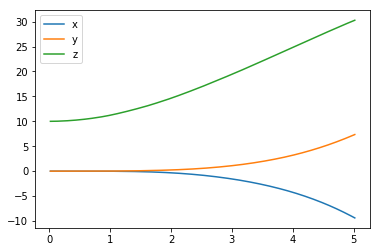

In [4]:
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

The next code cell visualizes the velocity of the quadcopter.

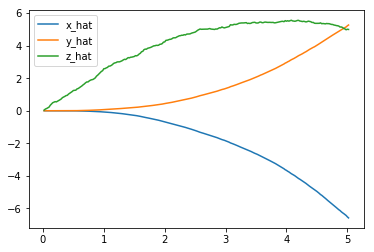

In [5]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

Next, you can plot the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes),

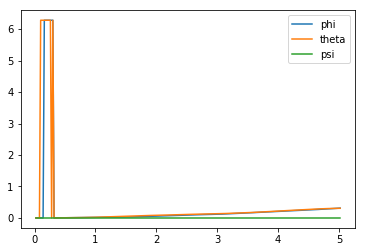

In [6]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

before plotting the velocities (in radians per second) corresponding to each of the Euler angles.

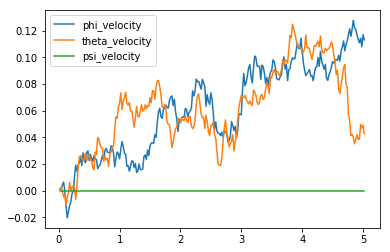

In [7]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

Finally, you can use the code cell below to print the agent's choice of actions.  

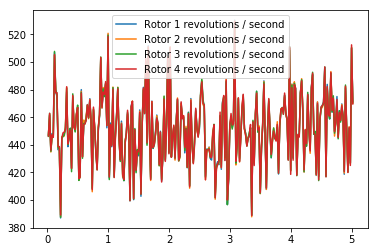

In [8]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

When specifying a task, you will derive the environment state from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In [9]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[-9.38578089  7.34732537 30.28321632  0.31107528  0.30599292  0.        ]
[-6.58318688  5.26746353  4.99435129]
[0.11303769 0.04260256 0.        ]


In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for your purposes, you are welcome to expand the size of the state vector by including the velocity information.  You can use any combination of the pose, velocity, and angular velocity - feel free to tinker here, and construct the state to suit your task.

## The Task

A sample task has been provided for you in `task.py`.  Open this file in a new window now. 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, you will learn how to test the performance of an agent on this task.

## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.

In [10]:
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task

num_episodes = 1000
target_pos = np.array([0., 0., 160.])
task = Task(target_pos=target_pos, runtime=5, init_pose=np.array([0.0, 0.0, 150., 0.0, 0.0, 0.0]))
agent = PolicySearch_Agent(task) 

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, total reward = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

Episode = 1000, total reward = -74636071.826 (best = -1502483.540), noise_scale = 3.2.2e = 3.222

## Agent Visualization - Quadcopter Flight Trajectory Plotting
* Red, green and blue lines denotes the orientation of the quadcopter at a moment.
* The black line denotes the trajectory.

In [11]:
# import sys
# !{sys.executable} -m pip install pyquaternion

flight time: 0.060 seconds, total reward: -1502483.540
final position: [  3.015 -10.582 300.000]
finished running test; available for plotting.


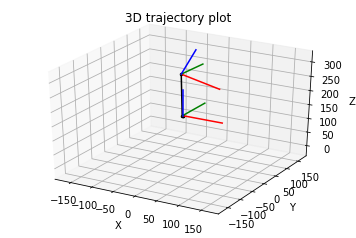

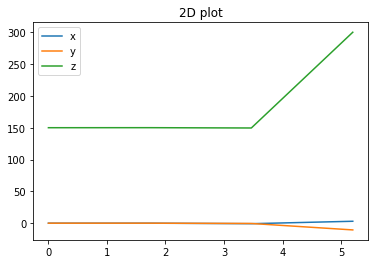

In [12]:
from Trajectory import Trajectory
trajectory = Trajectory()
trajectory.run_test(agent)
trajectory.plot_trajectory(show_orientations=True, every_n=5)

## Save Model

In [13]:
save_model = True
if save_model:
    import pickle
    with open('models/agent.pkl', 'wb') as agent_file:
        pickle.dump(agent, agent_file)

In [14]:
# print(trajectory.poses[-1][:3])
# print(trajectory.poses[-2][:3])

This agent should perform very poorly on this task.  And that's where you come in!

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [15]:
## TODO: Train your agent here.
import sys
import pandas as pd
from agents.agent import DDPG
from task import Task

np.set_printoptions(formatter={'float': '{:7.3f}'.format})
num_episodes = 500
target_pos = np.array([0.0, 0.0, 160.0])
ddpg_task = Task(target_pos=target_pos, runtime=5, init_pose=np.array([0.0, 0.0, 150.0, 0.0, 0.0, 0.0]))
ddpg_agent = DDPG(ddpg_task)
total_rewards = []
total_episodes = 0

for i_episode in range(1, num_episodes+1):
    state = ddpg_agent.reset_episode() # start a new episode
    total_reward = 0.0
    while True:
        action = ddpg_agent.act(state)
        next_state, reward, done = ddpg_task.step(action)
        ddpg_agent.step(action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            print("\rEpisode = {:4d}, total reward = {:7.3f}, final position: {}, final angular v: {}, flight time: {:4.2f}".format(
                total_episodes+i_episode, total_reward, ddpg_task.sim.pose[:3], ddpg_task.sim.angular_v, ddpg_task.sim.time), end="")  # [debug]
            total_rewards.append(total_reward)
            break
    sys.stdout.flush()
total_episodes += num_episodes

Using TensorFlow backend.


Episode =  500, total reward = -6990.467, final position: [  0.000  -0.961 222.508], final angular v: [ -0.054  -0.000   0.000], flight time: 5.0220

## Run for More Episodes if Wanted

In [ ]:
extra_num_episodes = 500
for i_episode in range(1, extra_num_episodes+1):
    state = ddpg_agent.reset_episode() # start a new episode
    total_reward = 0.0
    while True:
        action = ddpg_agent.act(state)
        next_state, reward, done = ddpg_task.step(action)
        ddpg_agent.step(action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            print("\rEpisode = {:4d}, total reward = {:7.3f}, final position: {}, final angular v: {}, flight time: {:4.2f}".format(
                total_episodes+i_episode, total_reward, ddpg_task.sim.pose[:3], ddpg_task.sim.angular_v, ddpg_task.sim.time), end="")  # [debug]
            total_rewards.append(total_reward)
            break
    sys.stdout.flush()
total_episodes += extra_num_episodes

In [ ]:
np.set_printoptions(formatter={'float': '{:7.3f}'.format})
print("position: {}".format(ddpg_task.sim.pose[:3]))
print("velocity: {}".format(ddpg_task.sim.v))
print("angular v: {}".format(ddpg_task.sim.angular_v))

## Agent Visualization - Quadcopter Flight Trajectory Plotting
* Red, green and blue lines denotes the orientation of the quadcopter at a moment.
* The black line denotes the trajectory.

/home/ubuntu/RL-Quadcopter-2/physics_sim.py:114: RuntimeWarning: invalid value encountered in double_scalars
  J = V / n * D
/home/ubuntu/RL-Quadcopter-2/physics_sim.py:114: RuntimeWarning: divide by zero encountered in double_scalars
  J = V / n * D


flight time: 5.020 seconds, total reward: -6978.654
final position: [  0.000   0.000 222.455]
finished running test; available for plotting.


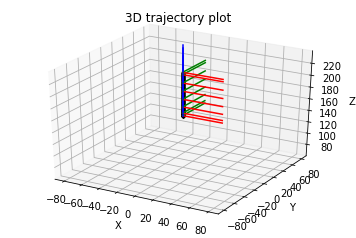

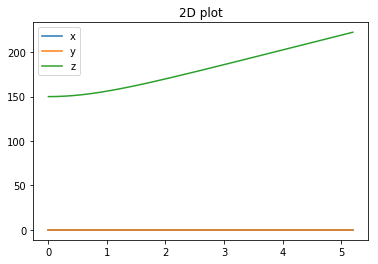

In [18]:
from Trajectory import Trajectory
trajectory = Trajectory()
trajectory.run_test(ddpg_agent)
trajectory.plot_trajectory(show_orientations=True, every_n=40)

## Save Model

In [30]:
# TypeError: can't pickle _thread.lock objects
# save_model = True
# if save_model:
#     import pickle
#     with open('models/ddpg_agent.pkl', 'wb') as agent_file:
#         pickle.dump(ddpg_agent, agent_file)

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

Text(0.5,1,'rewards')

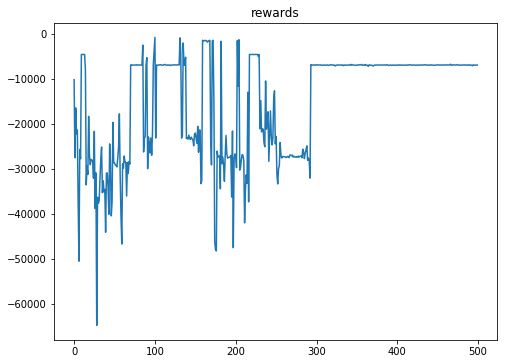

In [19]:
## TODO: Plot the rewards.
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0.1,0.1,0.88,0.88])
ax.plot(range(len(total_rewards)), total_rewards)
ax.set_title("rewards")

Text(0.5,1,'last 200 rewards')

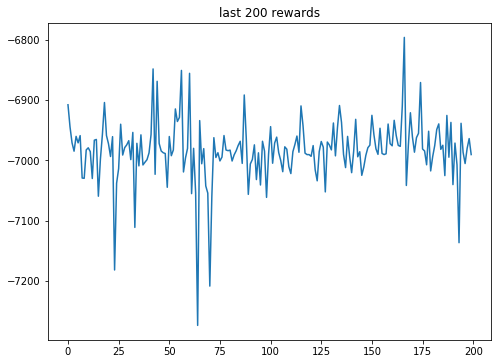

In [20]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0.1,0.1,0.88,0.88])
ax.plot(range(len(total_rewards[-200:])), total_rewards[-200:])
ax.set_title("last 200 rewards")

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:    
The task I specified in `task.py` is **rising from 150m to 160m without too much twisting around**.    
The reward function consists of two parts:  
1. the position score which denotes how close the quadcopter is to the target position.
2. the angular score which gives high value for low angular velocities.  

Note:
* The initial height is set to 150 to allow space for exploration.
* Score1 has a square dependency to strongly emphasize on closeness to prevent learning a fast dropping strategy.
* Score2 also has a square dependency to match against score1 in magnitude.
* Score2 is mutliplied by 0.1 in order to priotize **rising** over **no-twisting**

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:

- The learning algorithm I use is DDPG (Deep Deterministic Policy Gradients) [reference paper](https://arxiv.org/pdf/1509.02971.pdf). This is the only algorithm I tried and it seems to work fairly well. 
- The final hyperparameters are:
    1. discount factor $\gamma$ = 0.995
    2. soft update for target model $\tau$ = 0.01
    3. replay buffer size = 100000
    4. replay batch size = 128
    5. exploration noise $\theta$ = 0.15
    6. exploration noise $\sigma$ = 0.2
- Both the actor and the critic use neural networks.
    * The actor has 3 dense layers, with 64->64->4 nodes in each layer. Each has batch normalization and relu activation except that the last has sigmoid activation and no batch normalization.
    * The critic has two inputs--state and action--each going through a 32 nodes dense layers. They are then concatenated and go through a 64 nodes dense layers. Each of these layers has batch normalization and relu activation. In the end, a 1 node dense layer is used to generate Q value.

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:

- It was a fairly hard task to learn. I tried many different configurations for task and agent in order for the agent to generate behavior that somewhat resembles what is wanted. In terms of the reward plot, this particular agent took around 300 episodes to give the current behavior, which is probably not too bad.
- The learning curve has an aha moment at around 300 episodes, after which is fairly stable.
- The agent gives total rewards -6978 for an episode, which is much better than the policy_search agent. In terms of the actual behavior as plotted, the agent rises vertically from 150m to about 220m during the 5 seconds period, while the policy_search agent has a sudden crazy flight at .06 seconds.

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:

- A major difficulty with the project is the long time required to train the agent for a single configuration, while the resulting agent could not be easily stored to be used later. This limits the number of configurations that could be tested and explored in reasonable amount of time.
- Besides, it is quite difficult to pin down a proper reward function, as many times the rewards could be high while the behaviors were not what wanted.
- In the end, after seeing many agents that basically shoot off within a short time, it was fairly refreshing to get an agent that can rise vertically and stay within bounds for the entire 5 seconds.
- Currently the agent still goes about 60m higher than the target. But with more training, this error might decrease.